# Import data set

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
feats_to_keep = ['num_likes', 'text_str']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("drive/MyDrive/Final Project/story_data_new_feats.csv", 
                 usecols=feats_to_keep)

In [5]:
target = 'num_likes'

In [6]:
X = df[['text_str']]
y = df[target]

# Binarize target

In [7]:
threshold = np.quantile(y, 0.7)
threshold

13.0

In [8]:
print(f'It corresponds to {100*len(df[df[target]<=threshold][target])/len(df):.2f} percent of the stories being bad.')

It corresponds to 71.03 percent of the stories being bad.


In [9]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

# Split data train val test

In [10]:
X.shape, y.shape

((18248, 1), (18248, 1))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3, 
                                                    random_state=42,
                                                    shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                test_size=.5, 
                                                random_state=42,
                                                shuffle=False)

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

((12773, 1), (2737, 1), (2738, 1), (12773, 1), (2738, 1), (2737, 1))

In [12]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Import Transformer

In [13]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from transformers import LongformerTokenizer, TFLongformerForSequenceClassification
import tensorflow as tf

tokenizer = LongformerTokenizer.from_pretrained("hf-internal-testing/tiny-random-longformer")
model = TFLongformerForSequenceClassification.from_pretrained("hf-internal-testing/tiny-random-longformer")



Some layers from the model checkpoint at hf-internal-testing/tiny-random-longformer were not used when initializing TFLongformerForSequenceClassification: ['dropout_1142', 'lm_head', 'qa_outputs', 'classifier/bias:0', 'classifier/kernel:0']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerForSequenceClassification were initialized from the model checkpoint at hf-internal-testing/tiny-random-longformer.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLo

# Prepare model

In [16]:
model.layers[0].trainable=False

In [17]:
model.summary()

Model: "tf_longformer_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 longformer (TFLongformerMai  multiple                 98745     
 nLayer)                                                         
                                                                 
 classifier (TFLongformerCla  multiple                 1122      
 ssificationHead)                                                
                                                                 
Total params: 99,867
Trainable params: 1,122
Non-trainable params: 98,745
_________________________________________________________________


# Prepare data 

In [18]:
X_train.shape

(12773, 1)

In [19]:
%%time
max_length = 4096
X_train = tokenizer(X_train.text_str.tolist(), 
                    truncation=True, 
                    padding='max_length', 
                    max_length=max_length,
                    return_tensors="tf")

X_test = tokenizer(X_test.text_str.tolist(), 
                   truncation=True, 
                   padding='max_length', 
                   max_length=max_length,
                    return_tensors="tf")

X_val = tokenizer(X_val.text_str.tolist(), 
                  truncation=True, 
                  padding='max_length', 
                  max_length=max_length,
                    return_tensors="tf")

CPU times: user 4min 32s, sys: 8.12 s, total: 4min 40s
Wall time: 4min 49s


In [20]:
len(X_train['input_ids'])

12773

In [21]:
X_train = [np.array(X_train.input_ids)]
X_test = [np.array(X_test.input_ids)]
X_val = [np.array(X_val.input_ids)]

In [65]:
X_train[0].shape, y_train.shape

((12773, 4096), (12773, 1))

In [22]:
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

In [67]:
X_train[0].shape, y_train.shape

((12773, 4096), (12773,))

# Train model

In [37]:
import tensorflow as tf

In [23]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam', 
              loss=LOSS,
              metrics='accuracy')

In [32]:
%%time

model.fit(X_train, y_train, 
          batch_size=32, 
          validation_data=(X_val, y_val), 
          epochs=10)

Epoch 1/10
400/400 [==============================] - 217s 542ms/step - loss: 0.6038 - accuracy: 0.7096 - val_loss: 0.6058 - val_accuracy: 0.7064
Epoch 2/10
400/400 [==============================] - 211s 528ms/step - loss: 0.6044 - accuracy: 0.7096 - val_loss: 0.6054 - val_accuracy: 0.7064
Epoch 3/10
400/400 [==============================] - 207s 518ms/step - loss: 0.6029 - accuracy: 0.7096 - val_loss: 0.6060 - val_accuracy: 0.7064
Epoch 4/10
400/400 [==============================] - 209s 522ms/step - loss: 0.6041 - accuracy: 0.7096 - val_loss: 0.6066 - val_accuracy: 0.7064
Epoch 5/10
 19/400 [>.............................] - ETA: 2:48 - loss: 0.6030 - accuracy: 0.7122

KeyboardInterrupt: ignored

# Results

In [27]:
# apply softmax to each row --> probability (for AUC)
from scipy.special import softmax

# argmax: get 0 and 1

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [30]:
def display_results(y_pred_all, y_true, recall_value=.7):
  # get prediction
  y_pred = np.argmax(y_pred_all, axis=1)

  # get probability
  y_probs = softmax(y_pred_all)


  # classification report
  print(classification_report(y_true, y_pred))
  print('\n')

  # confusion matrix
  print('Confusion matrix:')
  print(confusion_matrix(y_true, y_pred))
  print('\n')


  # roc
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probs[:,1])
  auc = roc_auc_score(y_true, y_probs[:,1])

  plt.figure(figsize=(10,10))
  plt.plot(fpr, tpr, label=f'transformer, AUC={auc:.4f}')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title("Receiver operating characteristic ")
  plt.xlabel('rate of false positives')
  plt.ylabel('rate of true positives')
  plt.legend(loc='best')
  plt.show()
  print('\n')

  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')

  print('\n')


  # play with threshold
  precision, recall, thresholds = precision_recall_curve(y_true, y_probs[:,1])

  x = np.linspace(0,1, num=len(precision))
  y = interp1d(recall, precision)
  precision_value = y(recall_value)
  plt.figure(figsize=(10,10))
  plt.plot(recall, precision, label='transformer')
  plt.title("precision-recall curve")
  plt.plot(x, [precision_value]*len(recall), label=f'{precision_value:.2f}')
  plt.axvline(recall_value, label=f'{recall_value:.2f}')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.legend()
  plt.show()

  if len(thresholds)<len(recall):
    thresholds = np.append(thresholds,0)
  y_thresholds = interp1d(recall, thresholds)
  threshold_value = y_thresholds(recall_value)
  print('\n')
  print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.2f},\
  and the threshold is equal to {threshold_value:.2f}.')

  y_pred = (y_probs[:,1] >= threshold_value).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')
  print('\n')
  print(f"Confusion matrix when p={threshold_value:.2f}:")
  print(confusion_matrix(y_true, y_pred))

In [33]:
y_pred = model.predict(X_test)


86/86 [==============================] - 36s 417ms/step


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1963
           1       0.00      0.00      0.00       774

    accuracy                           0.72      2737
   macro avg       0.36      0.50      0.42      2737
weighted avg       0.51      0.72      0.60      2737



Confusion matrix:
[[1963    0]
 [ 774    0]]




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


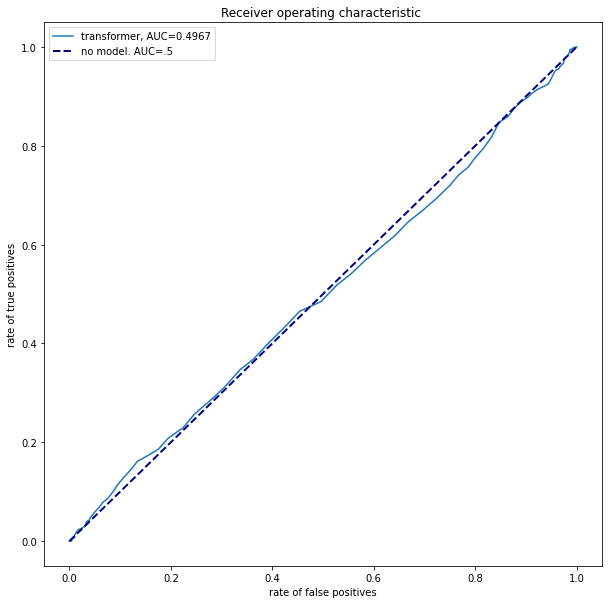



0.00% of the good stories are rightly identified.
0.00% of the bad stories are identified as good ones.




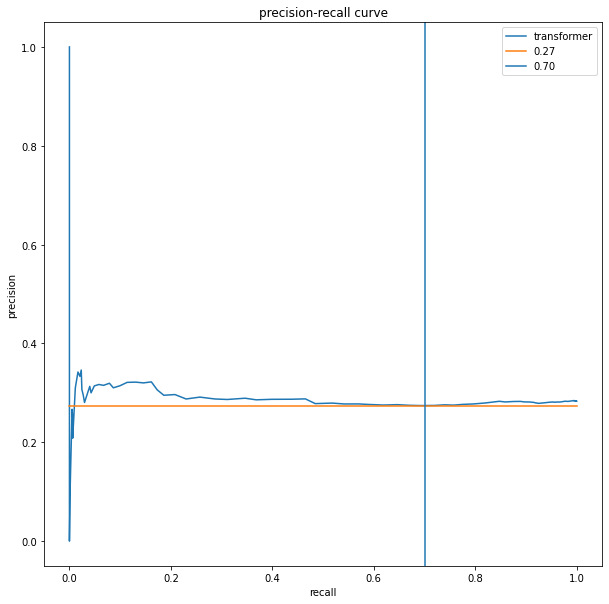



When recall is equal to 0.70, precision is equal to 0.27,  and the threshold is equal to 0.00.
69.38% of the good stories are rightly identified.
72.39% of the bad stories are identified as good ones.


Confusion matrix when p=0.00:
[[ 542 1421]
 [ 237  537]]


In [34]:
display_results(y_pred.logits, y_test, recall_value=.7)

# Examples

In [35]:
# this is supposed to be a good story
text = \
"""
The night is thick and heavy with clouds when I paint the front of The House yellow. I paint quickly and quietly. I don’t want to wake my neighbor up. The brush goes shhh shhh against the wall and even that is loud. 

My feet crunch on gravel as I finish up and slip into my home. 

My neighbor’s cursing wakes me up in the morning. I hear fuck! and shit! I split the blinds with two fingers. The sun shines very bright and I squint to see my other neighbors file outside. They see the yellow paint and shake their heads. One of them points at my home. I come away from the window. Knock knock. I do not answer. I make myself toast with a poached egg. I eat it plain. Butter has a strange, slimy texture and most jams are too sweet for my taste. 

They pound on the door. The doorknob rattles in its socket before I hear silence on my front porch again. 

My neighbors assume I painted The House. They are right, but it’s still insulting that they point to me first.

Upon purchase, my new neighbor repainted The House beige before moving equally bland furniture (and herself) inside. I must fix it. She does not understand that each house claims life as we do. Their creaks are small sighs and groans, their breath the wind that flutters curtains when their mouths are unlocked. Each house is individual in personality. They have different mannerisms, likes and dislikes that can influence whoever its inhabitant might be at the time. Often, though, its influence is overruled by tenants that bustle about, creating their own noises that muffle their homes.  

I can hear them. I hear anger when doors slam shut, peace when furniture is aligned and floors are swept clean. Houses do not have control over their appearance, so I help them. I listen and give them a color true to their individuality. 

The House in question, which you could say is my current “client,” is bubbly, but prone to sickness and somewhat oblivious to the struggles of others. It loves its inhabitants—most of the time—and wishes to give them a cozy embrace. Most of all, The House is very particular about its appearance and becomes incensed when the smallest thing is not quite right. Right now, it is sulking. The little yellow I gave it placated it, but soon it will demand more.  

In the afternoon I hear the grrr grrr of trucks and metallic clanking and deep voices shouting. Big men in loose denim pants and ugly T-shirts paint The House back to beige. My neighbor comes onto her lawn to survey the men, pointing out the spots that need extra paint. The painters finish quickly, taking my neighbor’s cash and leaving extra paint cans and brushes and crinkled plastic tarps. 

The House strains against its new skin. It pummels its beige bonds with angry fists and wails It’s so ugly! The neighboring houses think it silly and childish, but they are too old to remember what it was like to be a child. I will The House to be patient. Its paint is still wet. 


"""
inp = tokenizer(text, return_tensors='tf')
if np.argmax(model(inp).logits) == 0:
  print('Bad text')
else:
  print('Wha, good text')


Bad text
